# Extract figures


https://docs.scipy.org/doc/scipy/reference/tutorial/ndimage.html  
http://www.scipy-lectures.org/advanced/image_processing/#feature-extraction

In [1]:
from scipy import ndimage
from scipy import misc

import numpy as np

from wand.image import Image

import matplotlib.pyplot as plt
%matplotlib inline

import os
import pickle

In [2]:
def extract_figures( I ):
    B =  I < 200    # Convert to binary

    filled = ndimage.binary_fill_holes( B ) # comble les zones creuses
    
    innerzones = np.logical_and( np.logical_not(B), filled ) # ne garder que les zones creuses
    
    # filtres :
    N_iterations = 3
    innerzones = ndimage.binary_closing( innerzones, iterations=N_iterations ) # connecte les zones proches
    innerzones = ndimage.binary_opening( innerzones, iterations=N_iterations ) # supprime les petites zones

    IZ_label, nb_labels = ndimage.label( innerzones )   # segmentation

    sizes = ndimage.sum( innerzones , IZ_label, range(nb_labels+1) ) # calcul le nombre de pixel dans chaque cluster

    MIN_SIZE = 1600   # taille minimal pour accepter un cluster comme figure

    # Arret du script : il n'y a pas de figure
    if max( sizes ) < MIN_SIZE:
        return [] 

    # Efface les labels des clusters trop petit
    mask_size = sizes < MIN_SIZE
    remove_pixel = mask_size[ IZ_label ]
    IZ_label[remove_pixel] = 0

    # Sauvegarde la position des figures
    Pict = IZ_label>0  # masque permettant de localiser ensuite les schémas

    # Construction de la matrice de connection
    SIZE = 17
    M = np.zeros( (SIZE, SIZE) )
    M[ int(SIZE/2), int(SIZE/2) ] = 1
    M = ndimage.binary_dilation(M, iterations=int(SIZE/2)).astype(M.dtype)
    
    # Dilation
    B = ndimage.binary_dilation(B, structure=M) 

    # on combine les zones creuses avec la dilatation
    B = np.logical_or( B, Pict )
    
    # Segmentation une nouvel fois
    B_label, nb_labels = ndimage.label( B )

    # Est-ce qu'il y a une image ici ? 
    func = lambda I, pos: np.logical_and(I, Pict.flatten()[pos]).any()

    label_pict = ndimage.labeled_comprehension(B, B_label, range(nb_labels+1), func,\
                        out_dtype='bool', default=False, pass_positions=True)

    # si il n'y a aucun pixel commun entre le nouveau cluster (avec dilation) et 
    # les premiers obtenus (après filtrage sur le nombre de pixel)
    # alors ce n'est pas une image

    remove_pixel = np.logical_not(label_pict)[ B_label ]
    B_label[remove_pixel] = 0

    # Renome les labels
    labels = np.unique(B_label)
    B_label = np.searchsorted(labels, B_label)

    # Compute the bounting box
    bounting_box = ndimage.measurements.find_objects(B_label)

    cropped_images = []
    # crop and erase unwanted pixels 
    for k, bbox in enumerate( bounting_box ):
        Icrop = np.copy( I[ bbox ] )
        mask_erase =  B_label[ bbox ] != k+1
        Icrop[ mask_erase ] = 255

        cropped_images.append( Icrop )

    return cropped_images 

http://mikelynchgames.com/software-development/using-wand-to-extract-pngs-from-pdfs/

https://stackoverflow.com/a/37032551/8069403

In [3]:
def extract_from_pdf( pdfpath ):
    cropped_images = []

    # Lecture du pdf avec Wand (imageMagick) et conversion en ndarray
    # une resolution de 160dpi donne une image de ~1200px
    with Image(filename=pdfpath, resolution=160) as pdf_imgs:

        for page in pdf_imgs.sequence: # iteration sur les pages
            with Image(page) as Ipage:
                # ... read png image from binary string python ???
                #I = np.asarray(bytearray( Ipage.make_blob() ), dtype=np.uint8 ) 
                Ipage.format = 'png8'

                Ipage.save(filename='temp_image.png')      
                I_reloaded = misc.imread('temp_image.png', mode='L')

                cropped_images.extend( extract_figures( I_reloaded ) )

    #print(len(cropped_images))
    return cropped_images

In [4]:
# Retrouve les figures 
    
FIGURESDIR = 'figures_extracted/'

def patentid_from_figname( figname ):
    return figname.split('-')[0]

def find_figures( patent_number ):
    FIGURESLIST = os.listdir( FIGURESDIR )
    patentfiglist = [ figname 
                        for figname in FIGURESLIST 
                        if patentid_from_figname( figname ) == patent_number  ]
                        
    return patentfiglist

def isthereafigure( pdf ):
    return len( find_figures( pdf.strip('.pdf') ) )>0

In [5]:
# test
find_figures( 'US515828' )

['US515828-fig1.png',
 'US515828-fig2.png',
 'US515828-fig3.png',
 'US515828-fig0.png']

In [6]:
pdfdir = 'pdfs/'
savedir = 'figures_extracted/'

allpdfs = os.listdir(pdfdir)
print( len(allpdfs))

348


In [7]:
isthereafigure( allpdfs[-1] )

True

In [8]:
# - init -
#pdfwithoutfigure = []
#pickle.dump( pdfwithoutfigure, open( "pdfwithoutfigure.pickle", "wb" ) )

In [9]:
pdfwithoutfigure = pickle.load( open( "pdfwithoutfigure.pickle", "rb" ) )
print(len(pdfwithoutfigure))

1


In [11]:
isnotprocessed = lambda pdf: not isthereafigure( pdf ) and pdf not in pdfwithoutfigure

remainingpdfs = [ pdf for pdf in allpdfs if isnotprocessed(pdf) ]
print(len( remainingpdfs ))

28


In [12]:
# -- Loop --
for pdfname in remainingpdfs:
    
    pdfpath = pdfdir + pdfname
    
    patentnumber = pdfname.strip('.pdf')
    
    cropped_images = extract_from_pdf( pdfpath )
    
    if len(cropped_images)==0:
        pdfwithoutfigure.append(pdfname)
        print( '%s no figure'%pdfname )
        continue
    
    print('%s : %i figures' % (pdfname, len(cropped_images)))
    
    for k, Iarray in enumerate( cropped_images ):
        imagename = '%s-fig%i.png' % (patentnumber, k)
        misc.imsave(savedir+imagename, Iarray )
        #print( '  ' + imagename + " sauvegardée" )
        
pickle.dump( pdfwithoutfigure, open( "pdfwithoutfigure.pickle", "wb" ) )

US20110290080.pdf : 6 figures
US20130319446.pdf : 17 figures
US20130212884.pdf : 8 figures
US20140202003.pdf : 11 figures
US8082668.pdf : 3 figures
US8863758.pdf : 4 figures
US8578612.pdf : 9 figures
US8667691.pdf : 20 figures
US8683700.pdf : 20 figures
US20140014042.pdf : 14 figures
US20140041195.pdf : 16 figures
US8096305.pdf : 6 figures
US20120011723.pdf : 10 figures
US20110079234.pdf : 2 figures
US20120210583.pdf : 43 figures
US20140250692.pdf : 56 figures
US8356414.pdf : 13 figures
US7913391.pdf : 9 figures
US20130000125.pdf : 22 figures
US20130067748.pdf : 11 figures
US8100088.pdf : 20 figures
US20110154667.pdf : 34 figures
US20140215829.pdf : 8 figures
US8365415.pdf : 4 figures
US20140325846.pdf : 15 figures
US20130327348.pdf : 1 figures
US8096053.pdf : 22 figures
US8726516.pdf : 42 figures


# brouillon

In [83]:
imagename = patentnumber

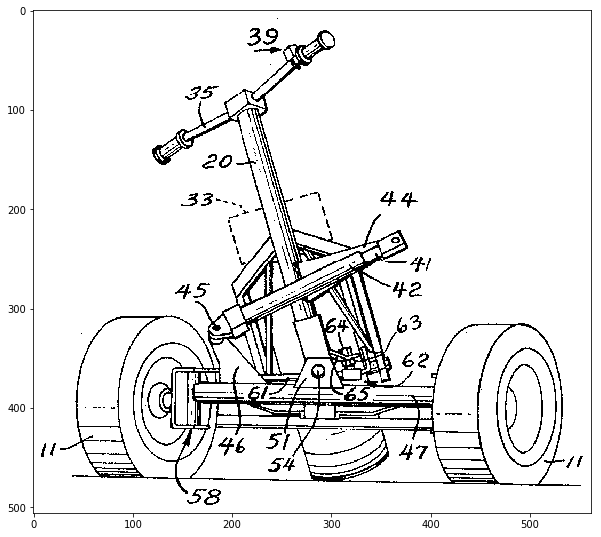

In [82]:
plt.figure( figsize=(10, 10) )
plt.imshow( cropped_images[5], cmap='gray'  );

In [26]:
filename = 'images/US3746118-page-1.png' #"images/test-3.png"
I = misc.imread(filename, mode='L') # ‘L’ (8-bit pixels, black and white)

In [28]:
cropped_images = extract_figures( I )
print(len(cropped_images))

3


In [112]:
def extract_figures_old( I ):
    B =  I < 127    # Convert to binary

    B_label, nb_labels = ndimage.label( B )   # segmentation

    sizes = ndimage.sum( B , B_label, range(nb_labels+1) ) # calcul le nombre de pixel dans chaque cluster

    MIN_SIZE = 1600   # taille minimal pour accepter un cluster comme figure

    # Arret du script : il n'y a pas de figure
    if max( sizes ) < MIN_SIZE:
        print('no figure')
        return [] 

    # Efface les labels des clusters trop petit
    mask_size = sizes < MIN_SIZE
    remove_pixel = mask_size[ B_label ]
    B_label[remove_pixel] = 0

    # Filtre sur le ratio (pour les bande noir issus du scan)
    # Rename labels
    labels = np.unique(B_label)
    B_label = np.searchsorted(labels, B_label)

    bounting_box = ndimage.measurements.find_objects(B_label)
    
    RATIO_MAX = 25
    LENGTH_MAX = 1000
    for i, bbox in enumerate( bounting_box ):

        w, h = [ s.stop-s.start for s in bbox[:2] ]  
        ratio = max( w, h )/min( w, h )

        if ratio > RATIO_MAX or w>LENGTH_MAX or h>LENGTH_MAX:
            B_label[ B_label==i+1 ] = 0

    # Sauvegarde la position des figures
    Pict = B_label>0  # masque permettant de localiser ensuite les schémas

    # Construction de la matrice de connection
    SIZE = 17
    M = np.zeros( (SIZE, SIZE) )
    M[ int(SIZE/2), int(SIZE/2) ] = 1
    M = ndimage.binary_dilation(M, iterations=int(SIZE/2)).astype(M.dtype)

    # Dilation
    B = ndimage.binary_dilation(B, structure=M) 

    # Segmentation une nouvel fois de l'image
    B_label, nb_labels = ndimage.label( B )

    # Est-ce qu'il y a une image ici ? 
    func = lambda I, pos: np.logical_and(I, Pict.flatten()[pos]).any()

    label_pict = ndimage.labeled_comprehension(B, B_label, range(nb_labels+1), func,\
                        out_dtype='bool', default=False, pass_positions=True)

    # si il n'y a aucun pixel commun entre le nouveau cluster (avec dilation) et 
    # les premiers obtenus (après filtrage sur le nombre de pixel)
    # alors ce n'est pas une image

    remove_pixel = np.logical_not(label_pict)[ B_label ]
    B_label[remove_pixel] = 0

    # Renome les labels
    labels = np.unique(B_label)
    B_label = np.searchsorted(labels, B_label)

    # Compute the bounting box
    bounting_box = ndimage.measurements.find_objects(B_label)

    cropped_images = []
    # crop and erase unwanted pixels 
    for k, bbox in enumerate( bounting_box ):
        Icrop = np.copy( I[ bbox ] )
        mask_erase =  B_label[ bbox ] != k+1
        Icrop[ mask_erase ] = 255

        cropped_images.append( Icrop )

    return cropped_images 